In [2]:
import tensorflow as tf
print(tf.__version__)

2.11.0


In [4]:
import os
import warnings
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
#import onnx

warnings.filterwarnings("ignore")

In [5]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing import image
from tensorflow.keras import models
from tensorflow.keras.models import load_model
from tensorflow.keras import models
from PIL import Image 
from skimage.io import imread
import cv2

K.clear_session()

# <b>IMAGE PROCESSSING</b>

<h2>Reshaping dimensions so we can start processing arrays. </h2>

In [ ]:
img = plt.imread('../input/indian-food-classification/dataset/Dataset/train/pizza/033.jpg')
dims = np.shape(img)
matrix = np.reshape(img, (dims[0] * dims[1], dims[2]))
print(np.shape(matrix))

In [ ]:
plt.imshow(img)
print("Image shape -> ",dims[:2])
print("Color channels -> ",dims[2])
print("Min color depth : {}, Max color depth {}".format(np.min(img),np.max(img)))

<h2>Plot for visualizing pixel intensities for RGB in color space</h2>

In [ ]:
sns.distplot(matrix[:,0], bins=20,color="red",hist_kws=dict(alpha=0.3))
sns.distplot(matrix[:,1], bins=20,color="green",hist_kws=dict(alpha=0.35))
sns.distplot(matrix[:,2], bins=20,color="blue",hist_kws=dict(alpha=0.2))
plt.show()

<h2>Plot for visualizing histogram between 2 color channel</h2>

In [ ]:
_ = plt.hist2d(matrix[:,1], matrix[:,2], bins=(50,50))
plt.xlabel('Green channel')
plt.ylabel('Blue channel')
plt.show()

In [ ]:
import skimage
from skimage.feature import greycomatrix, greycoprops
from skimage.filters import sobel
from skimage.filters import sobel_h

plt.figure(1,figsize=(20,15))
cmap="YlGnBu"
plt.subplot(3,1,1)
plt.imshow(img)

plt.subplot(3,1,2)
plt.imshow(sobel(img[:,:,2]),cmap=cmap)

plt.subplot(3,1,3)
plt.imshow(sobel_h(img[:,:,1]), cmap=cmap)

plt.tight_layout()

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(3)
pca.fit(matrix)
img_pca = pca.transform(matrix)
img_pca = np.reshape(img_pca, (dims[0], dims[1], dims[2]))

fig = plt.figure(figsize=(8, 8))
plt.imshow(img_pca[:,:,1], cmap=cmap)

# <b>Exploratory Data Analysis (EDA)</b>

In [ ]:
main='C:\Miniproject\Dataset_new\Dataset\\train'

data=dict()

for i in os.listdir(main):
    sub_dir=os.path.join(main,i)
    count=len(os.listdir(sub_dir))
    data[i]=count
    
  
keys = data.keys()
values = data.values()

colors=["red" if x<= 150 else "green" for x in values]

fig, ax = plt.subplots(figsize=(12,8))
y_pos=np.arange(len(values))
plt.barh(y_pos,values,align='center',color=colors)
for i, v in enumerate(values):
    ax.text(v+1.4, i-0.25, str(v), color=colors[i])
ax.set_yticks(y_pos)
ax.set_yticklabels(keys)
ax.set_xlabel('Images',fontsize=16)
plt.xticks(color='black',fontsize=13)
plt.yticks(fontsize=13)
plt.show()

In [ ]:
import random

train_folder = "C:\Miniproject\Dataset_new\Dataset\\train"
images = []

for food_folder in sorted(os.listdir(train_folder)):
    food_items = os.listdir(train_folder + '/' + food_folder)
    food_selected = np.random.choice(food_items)
    images.append(os.path.join(train_folder,food_folder,food_selected))
                                     
fig=plt.figure(1, figsize=(25, 25))

for subplot,image_ in enumerate(images):
    category=image_.split('/')[-2]
    imgs = plt.imread(image_)
    a,b,c=imgs.shape
    fig=plt.subplot(5, 4, subplot+1)
    fig.set_title(category, pad = 10,size=18)
    plt.imshow(imgs)
    
plt.tight_layout()

# <b> MODEL TRAINING </b>

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

n_classes = 25
batch_size = 10
img_width, img_height = 299, 299

train_data_dir = 'C:\Miniproject\Dataset_new\Dataset\\train'

# Data Augmentation with ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

val_data_dir = 'C:\Miniproject\Dataset_new\Dataset\\val'

val_datagen = ImageDataGenerator(rescale=1. / 255)

val_generator = val_datagen.flow_from_directory(
    val_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

Found 4162 images belonging to 25 classes.
Found 1299 images belonging to 25 classes.


In [2]:
class_map = train_generator.class_indices
class_map

{'bajji': 0,
 'biriyani': 1,
 'burger': 2,
 'butter_naan': 3,
 'chai': 4,
 'chapati': 5,
 'chole_bhature': 6,
 'curd_rice': 7,
 'dal_makhani': 8,
 'fried_rice': 9,
 'idli': 10,
 'jalebi': 11,
 'kaathi_rolls': 12,
 'kadai_paneer': 13,
 'kulfi': 14,
 'masala_dosa': 15,
 'methu_vadai': 16,
 'milkshake': 17,
 'momos': 18,
 'noodles': 19,
 'paani_puri': 20,
 'pakode': 21,
 'pav_bhaji': 22,
 'pizza': 23,
 'samosa': 24}

In [3]:
import tensorflow as tf
print(tf.__version__)
print(tf.test.gpu_device_name())

2.6.0
/device:GPU:0


## Training the model

In [4]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
# from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
# from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten


from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Dropout

from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2

from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger

nb_train_samples = 3583 
nb_validation_samples = 1089

inception = InceptionV3(weights='imagenet', include_top=False)
x = inception.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.2)(x)

predictions = Dense(n_classes,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

model = Model(inputs=inception.input, outputs=predictions)
model.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='v1_inceptionV3', verbose=1, save_best_only=True)
csv_logger = CSVLogger('history_v1_inceptionV3.log')

history = model.fit(train_generator,
                    steps_per_epoch = nb_train_samples // batch_size,
                    validation_data=val_generator,
                    validation_steps=nb_validation_samples // batch_size,
                    epochs=30,
                    verbose=1,
                    callbacks=[csv_logger, checkpointer])

c:\ProgramData\Anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/30
358/358 [==============================] - 193s 504ms/step - loss: 3.2262 - accuracy: 0.1576 - val_loss: 2.8793 - val_accuracy: 0.3741

Epoch 00001: val_loss improved from inf to 2.87933, saving model to v1_inceptionV3
INFO:tensorflow:Assets written to: v1_inceptionV3\assets
Epoch 2/30
358/358 [==============================] - 127s 355ms/step - loss: 2.6220 - accuracy: 0.4054 - val_loss: 2.1479 - val_accuracy: 0.5759

Epoch 00002: val_loss improved from 2.87933 to 2.14795, saving model to v1_inceptionV3
INFO:tensorflow:Assets written to: v1_inceptionV3\assets
Epoch 3/30
358/358 [==============================] - 121s 336ms/step - loss: 2.0374 - accuracy: 0.5553 - val_loss: 1.4697 - val_accuracy: 0.7556

Epoch 00003: val_loss improved from 2.14795 to 1.46969, saving model to v1_inceptionV3
INFO:tensorflow:Assets written to: v1_inceptionV3\assets
Epoch 4/30
358/358 [==============================] - 119s 331ms/step - loss: 1.5976 - accuracy: 0.6582 - val_loss: 1.1005 - val_ac

In [ ]:
history = model.fit(train_generator,
                    steps_per_epoch = nb_train_samples // batch_size,
                    validation_data=val_generator,
                    validation_steps=nb_validation_samples // batch_size,
                    epochs=10,
                    verbose=1,
                    callbacks=[csv_logger, checkpointer])

## Saving the model

In [8]:
model.save('model_v1_inceptionV3_new.h5')

## Accuracy and Loss curves

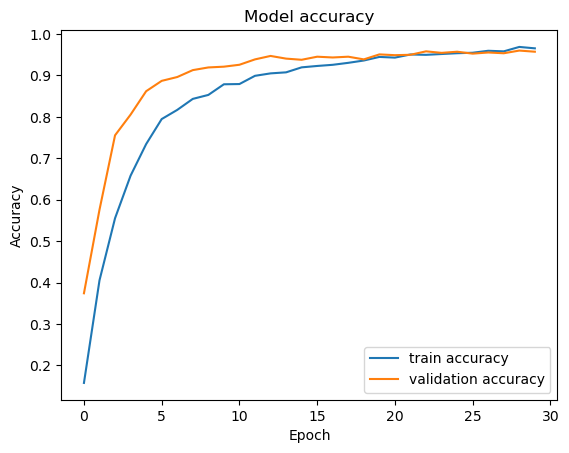

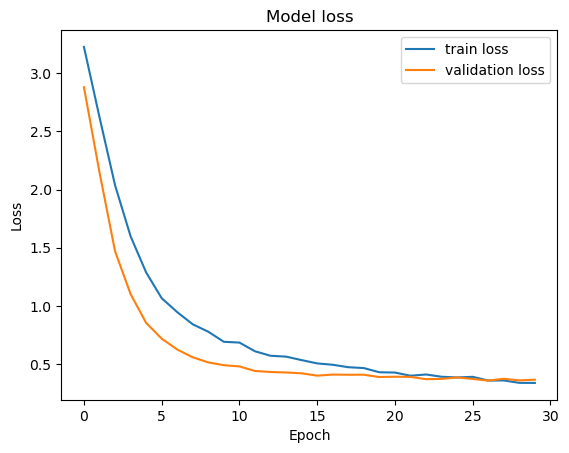

In [9]:
import matplotlib.pyplot as plt
def plot_accuracy(history):
    
    plt.plot(history.history['accuracy'],label='train accuracy')
    plt.plot(history.history['val_accuracy'],label='validation accuracy')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.savefig('Accuracy_v1_InceptionV3')
    plt.show()
    
def plot_loss(history):
    
    plt.plot(history.history['loss'],label="train loss")
    plt.plot(history.history['val_loss'],label="validation loss")
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.savefig('Loss_v1_InceptionV3')
    plt.show()
    
plot_accuracy(history)
plot_loss(history)

# <b> PREDICTIONS </b>

## Load the model

In [2]:
import os
import warnings
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models
from tensorflow.keras.models import load_model
from tensorflow.keras import models
from PIL import Image 
from skimage.io import imread
import cv2

K.clear_session()

In [3]:


path_to_model="C:\\Miniproject\\v1_inceptionV3\\model_v1_inceptionV3_new.h5"
print("Loading the model..")
model = load_model(path_to_model)
print("Done!")

Loading the model..
Done!


## Testing model on test set 

In [ ]:
test_data_dir = 'C:\Miniproject\\Dataset_new\\Dataset\\val'

test_datagen = ImageDataGenerator(rescale=1. / 255)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

In [15]:
evaluate_generatorscores = model.(test_generator)
print("Test Accuracy: {:.3f}".format(scores[1]))

Test Accuracy: 0.960


## Function to predict single image or predict all images from a directory

In [5]:
category={
    0:['bajji','Bajji'],1:['biriyani','Biriyani'],2:['burger','Burger'], 3: ['butter_naan','Butter Naan'], 4: ['chai','Chai'],
    5: ['chapati','Chapati'], 6: ['chole_bhature','Chole Bhature'], 7:['curd_rice','Curd rice'],8: ['dal_makhani','Dal Makhani'],
    9: ['fried_rice','Fried Rice'], 10: ['idli','Idli'], 11: ['jalegi','Jalebi'],
    12: ['kathi_rolls','Kaathi Rolls'], 13: ['kadai_paneer','Kadai Paneer'], 14: ['kulfi','Kulfi'],
    15: ['masala_dosa','Masala Dosa'],16:['methu_vadai','Methu vadai'] ,17:['milkshake','Milkshake'],18: ['momos','Momos'], 19:['noodles','Noodles'],20: ['paani_puri','Paani Puri'],
    21: ['pakode','Pakode'], 22: ['pav_bhaji','Pav Bhaji'], 23: ['pizza','Pizza'], 24: ['samosa','Samosa']
}

def predict_image(filename,model):
    img_ = image.load_img(filename, target_size=(299, 299))
    img_array = image.img_to_array(img_)
    img_processed = np.expand_dims(img_array, axis=0) 
    img_processed /= 255.   
    
    prediction = model.predict(img_processed)
    
    index = np.argmax(prediction)
    
    plt.title("Prediction - {}".format(category[index][1]))
    plt.imshow(img_array)
    
def predict_dir(filedir,model):
    cols=5
    pos=0
    images=[]
    total_images=len(os.listdir(filedir))
    rows=total_images//cols + 1
    
    true=filedir.split('/')[-1]
    
    fig=plt.figure(1, figsize=(25, 25))
    
    for i in sorted(os.listdir(filedir)):
        images.append(os.path.join(filedir,i))
        
    for subplot,imggg in enumerate(images):
        img_ = image.load_img(imggg, target_size=(299, 299))
        img_array = image.img_to_array(img_)
        
        img_processed = np.expand_dims(img_array, axis=0) 

        img_processed /= 255.
        prediction = model.predict(img_processed)
        index = np.argmax(prediction)
        
        pred=category.get(index)[0]
        if pred==true:
            pos+=1
        
        fig=plt.subplot(rows, cols, subplot+1)
        fig.set_title(category.get(index)[1], pad = 10,size=18)
        plt.imshow(img_array)

    acc=pos/total_images
    print("Accuracy of Test : {:.2f} ({pos}/{total})".format(acc,pos=pos,total=total_images))
    plt.tight_layout()

1/1 [==============================] - 0s 166ms/step


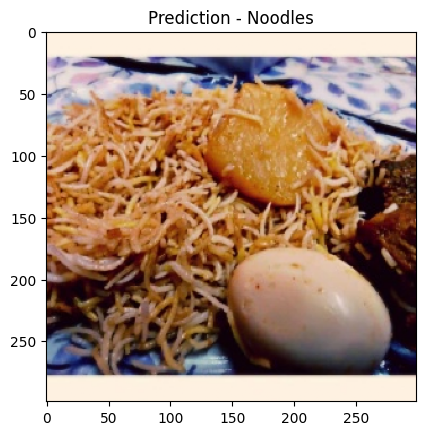

In [6]:
predict_image("C:\\Miniproject\\Dataset_new\\Dataset\\val\\biriyani\\JP04NR0OJTP1.jpg",model)

1/1 [==============================] - 0s 77ms/step
Accuracy of Test : 0.00 (0/67)


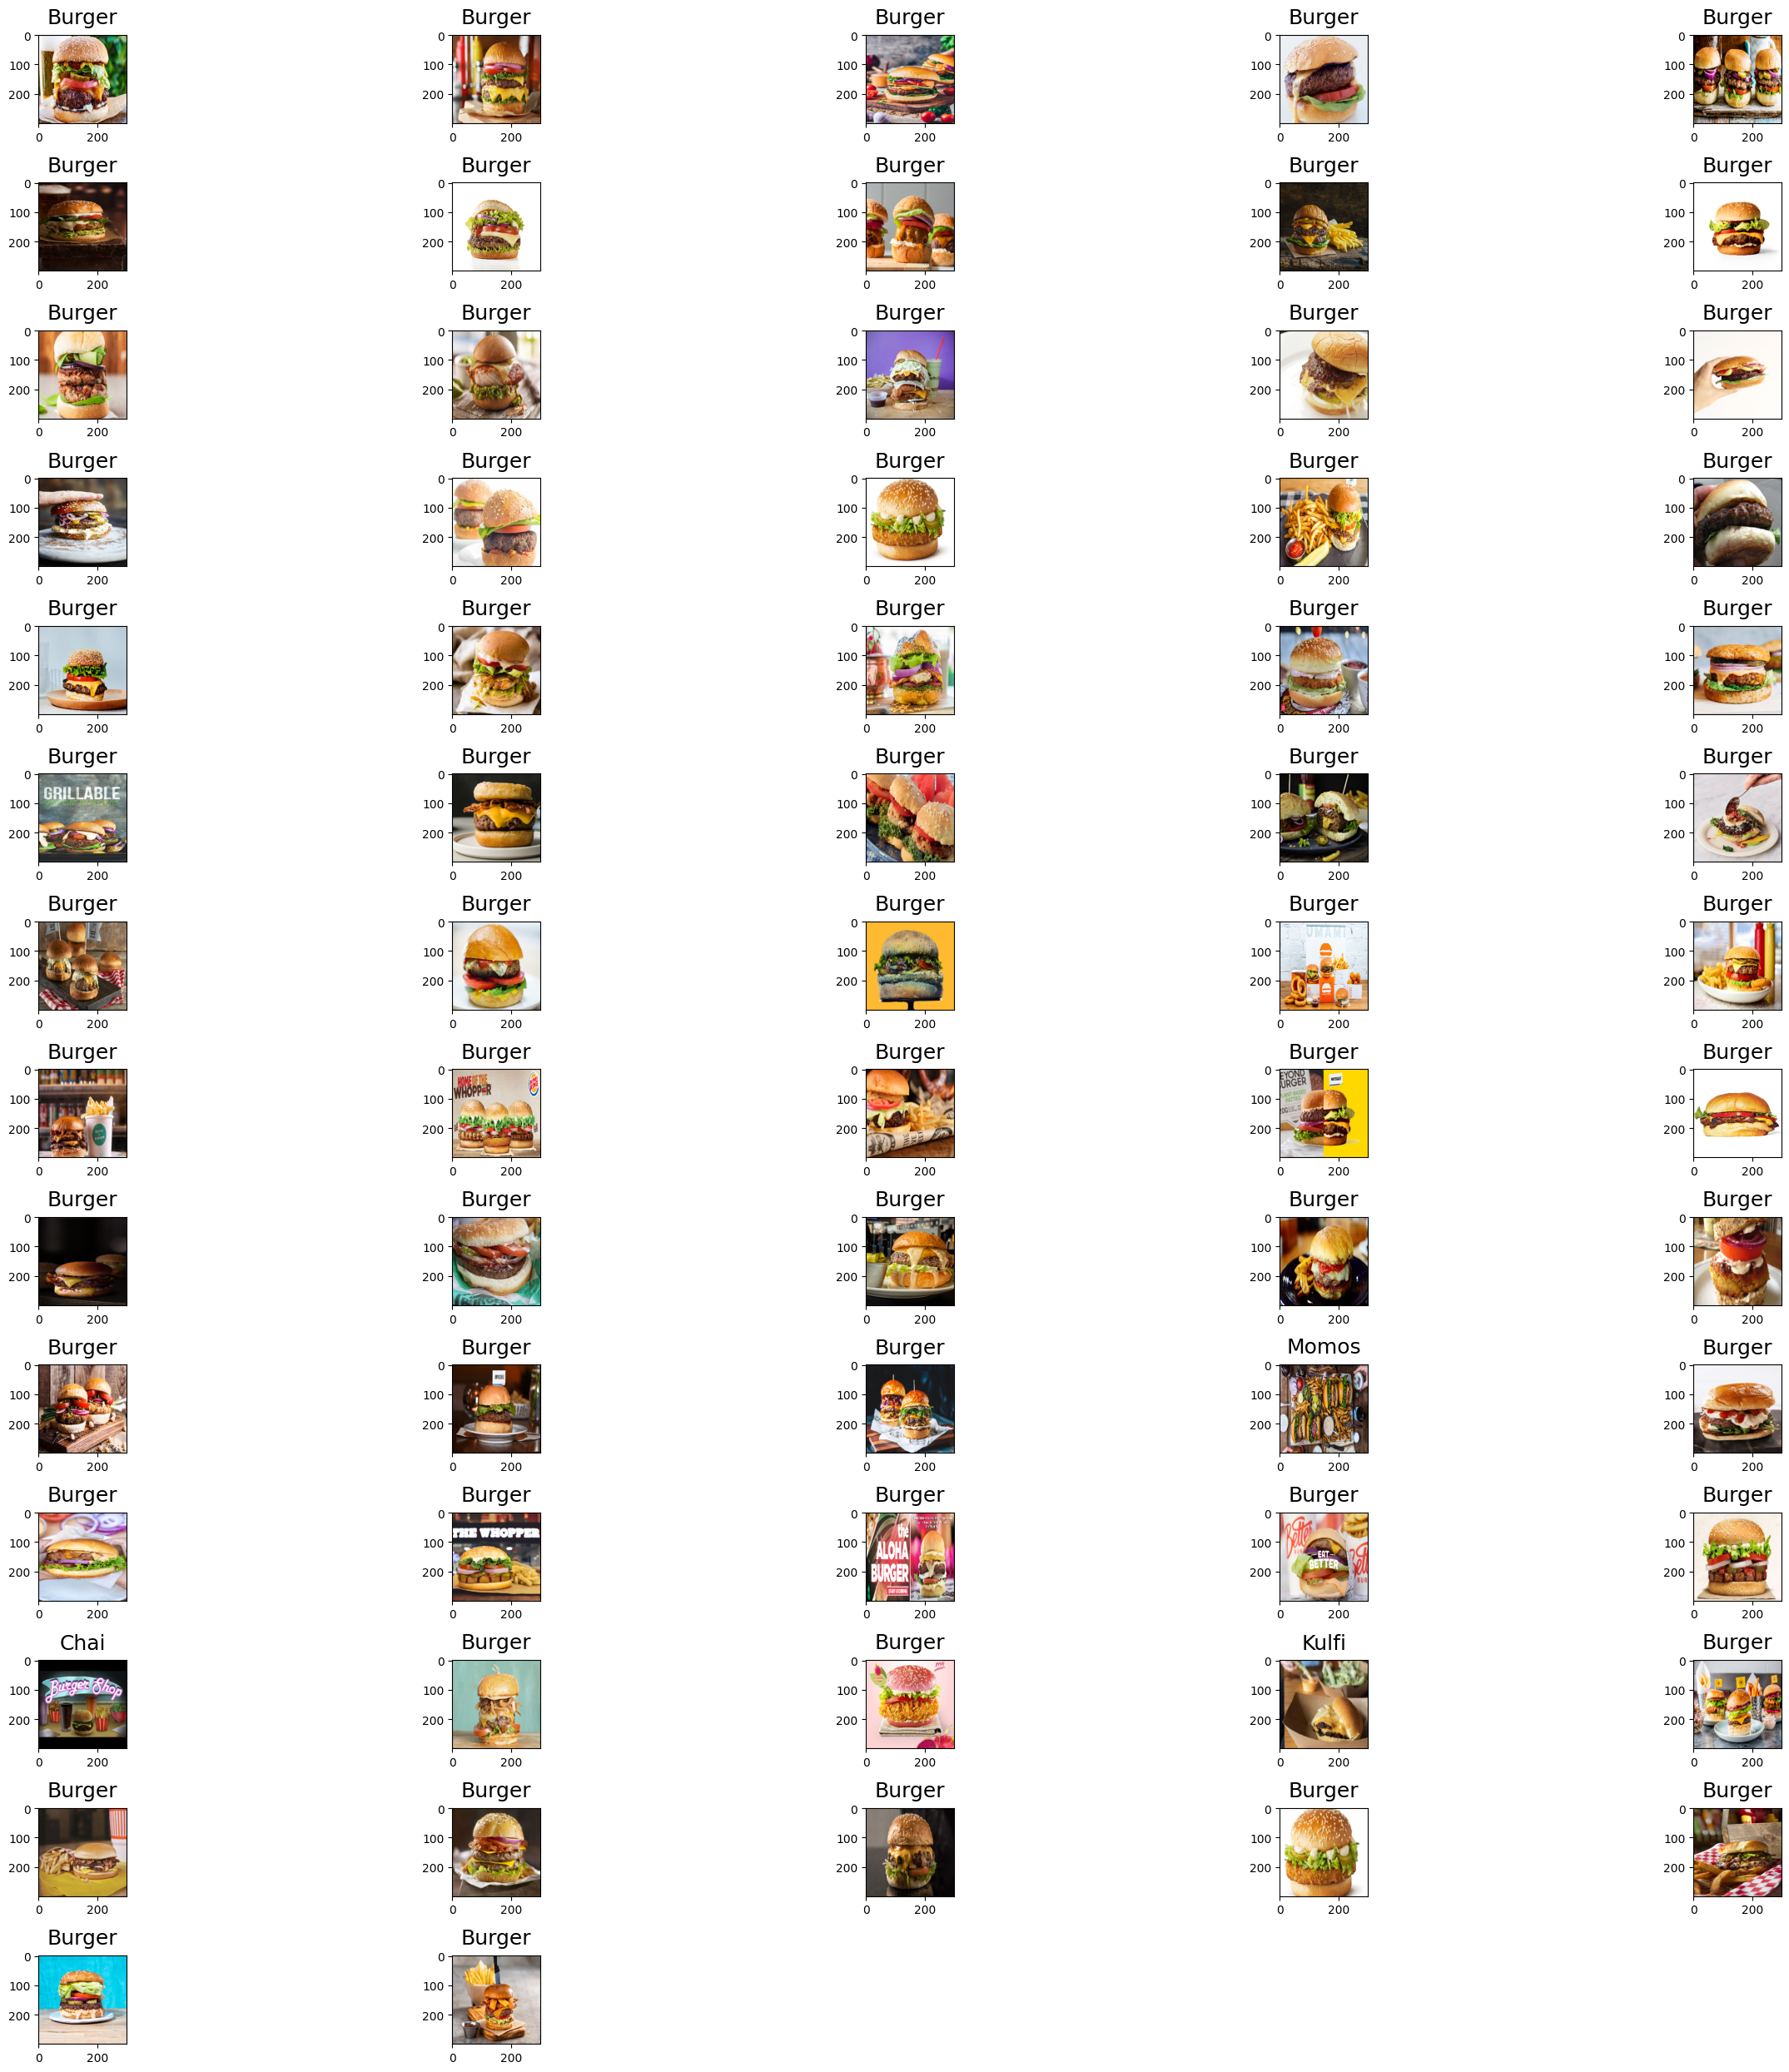

In [8]:
predict_dir("C:\\Miniproject\\Dataset_new\\Dataset\\val\\burger",model)